In [1]:
import numpy as np

In [2]:
bboxes = np.array(
    [
        [0.35462865, 0.11664762, 0.60693973, 0.5890224],
        [0.40342337, 0.20557676, 0.5616128,  0.5234643],
        [0.46127787, 0.32611138, 0.49125567, 0.4143357],
        [0.1, 0.2, 0.3, 0.4]
    ]
)
bbox_labels = np.array(["bus", "person", "bus", "person"], dtype=str)
bbox_scores = np.array([0.9973229, 0.65, 0.32002142, 0.20213117], dtype=float)

In [3]:
def filter_score_thres(arg_bboxes, arg_bbox_labels, arg_bbox_scores):
    score_thres = {
        "bus": 0.8,
        "person": 0.6,
    }
    mask = np.ones(arg_bbox_labels.shape, dtype=bool)
    for cls, thres in score_thres.items():
        mask &= (arg_bbox_labels == cls) & (arg_bbox_scores >= thres) | (
            arg_bbox_labels != cls
        )

    return arg_bboxes[mask], arg_bbox_labels[mask], arg_bbox_scores[mask]


In [4]:
bboxes, bbox_labels, bbox_scores = filter_score_thres(bboxes, bbox_labels, bbox_scores)


In [5]:
print(bboxes)
print(bbox_labels)
print(bbox_scores)

[[0.35462865 0.11664762 0.60693973 0.5890224 ]
 [0.40342337 0.20557676 0.5616128  0.5234643 ]]
['bus' 'person']
[0.9973229 0.65     ]


In [19]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt

from peekingduck.pipeline.nodes.draw.utils.constants import (
    PRIMARY_PALETTE,
    PRIMARY_PALETTE_LENGTH,
    VERY_THICK,
)
from peekingduck.pipeline.nodes.draw.utils.general import (
    get_image_size,
    project_points_onto_original_image,
)

In [12]:
img_path = list((Path.cwd().parent / "data" / "input" / "video_1" / "bus_oob_frames").glob("*.jpg"))[0]

In [55]:
def draw_zones(frame, zones):
    image_size = get_image_size(frame)

    for i, zone_pts in enumerate(zones):
        zone_pts = list(
            map(
                tuple,
                project_points_onto_original_image(zone_pts, image_size).astype(int),
            )
        )
        total_points = len(zone_pts)
        for j in range(total_points):
            cv2.line(
                frame,
                zone_pts[j],
                zone_pts[(j + 1) % total_points],
                PRIMARY_PALETTE[(i + 1) % PRIMARY_PALETTE_LENGTH],
                VERY_THICK,
            )


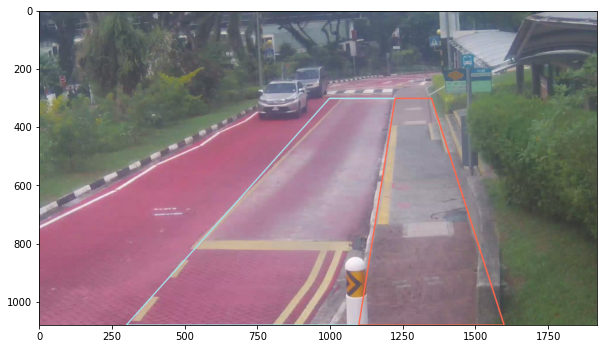

In [56]:
img = cv2.imread(str(img_path))
zones = np.array(
    [
        [
            [1000 / 1920, 300 / 1080],
            [1225 / 1920, 300 / 1080],
            [1100 / 1920, 1],
            [300 / 1920, 1],
        ],
        [
            [1225 / 1920, 300 / 1080],
            [1350 / 1920, 300 / 1080],
            [1600 / 1920, 1],
            [1100 / 1920, 1],
        ],
    ]
)

draw_zones(img, zones)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img[:, :, ::-1])


In [70]:
from shapely.geometry import Polygon

from peekingduck.pipeline.nodes.draw.utils.bbox import draw_bboxes

In [129]:
def get_img_path(frame_number):
    return (
        Path.cwd().parent
        / "data"
        / "input"
        / "video_1"
        / "bus_oob_frames"
        / f"video_1_{frame_number}.jpg"
    )


img_path_4455 = get_img_path(4455)
img_path_4493 = get_img_path(4493)

bbox_4455 = np.array([[0.39755455, 0.09465199, 0.60416126, 0.3764613]])
bbox_labels_4455 = ["bus"]

bbox_4493 = np.array([[0, 0, 0.40809625, 1]])
bbox_4493 = ["bus"]

bboxes = np.array(
    [
        [0.39755455, 0.09465199, 0.60416126, 0.3764613],
        [0, 0, 0.40809625, 1],
        [0.39755455, 0.19465199, 0.58416126, 0.5764613],
        [0, 0, 0.40809625, 1],
    ]
)
bbox_labels = np.array(["bus", "bus", "bus", "person"])


In [109]:
def bbox_to_polygon(bbox):
    return Polygon(
        [(bbox[0], bbox[1]), (bbox[2], bbox[1]), (bbox[2], bbox[3]), (bbox[0], bbox[3])]
    )


In [120]:
zone_poly = Polygon(zones[0])
for bbox in bboxes:
    bbox_poly = bbox_to_polygon(bbox)
    if zone_poly.intersects(bbox_poly):
        print(zone_poly.intersection(bbox_poly).area)
        print(zone_poly.intersection(bbox_poly).area / bbox_poly.area)

0.010681112398156369
0.18344958200794662
0.06282247141392855
0.15394033004206373
0.04068343059695522
0.571010109472116


In [130]:
def filter_zone_overlap(arg_bboxes, arg_bbox_labels, arg_bbox_scores):
    overlap_thres = {
        "bus": {
            "thres": 0.25,
            "zone": [
                [1000 / 1920, 300 / 1080],
                [1225 / 1920, 300 / 1080],
                [1100 / 1920, 1],
                [300 / 1920, 1],
            ],
        }
    }
    mask = np.ones(arg_bbox_labels.shape, dtype=bool)
    for cls, thres_d in overlap_thres.items():
        zone_poly = Polygon(thres_d["zone"])
        for i, (det_bbox, det_cls) in enumerate(zip(arg_bboxes, arg_bbox_labels)):
            if cls == det_cls:
                bbox_poly = bbox_to_polygon(det_bbox)
                if zone_poly.intersects(bbox_poly):
                    mask[i] = zone_poly.intersection(bbox_poly).area / bbox_poly.area >= thres_d["thres"]
                else:
                    mask[i] = False
    return arg_bboxes[mask], arg_bbox_labels[mask], arg_bbox_scores[mask]

filter_zone_overlap(bboxes, bbox_labels, bbox_labels.copy())

(array([[0.39755455, 0.19465199, 0.58416126, 0.5764613 ],
        [0.        , 0.        , 0.40809625, 1.        ]]),
 array(['bus', 'person'], dtype='<U6'),
 array(['bus', 'person'], dtype='<U6'))

In [127]:
overlap_thres = {"bus": 0.25}
mask = np.ones(bbox_labels.shape, dtype=bool)

zone_poly = Polygon(zones[0])
for cls, thres in overlap_thres.items():
    for i, (det_bbox, det_cls) in enumerate(zip(bboxes, bbox_labels)):
        if cls == det_cls:
            bbox_poly = bbox_to_polygon(det_bbox)
            if zone_poly.intersects(bbox_poly):
                mask[i] = zone_poly.intersection(bbox_poly).area / bbox_poly.area >= thres
            else:
                mask[i] = False
print(mask)


0.18344958200794662
0.15394033004206373
0.571010109472116
[False False  True]


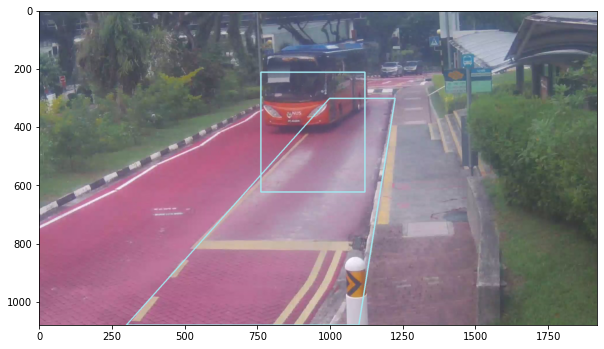

In [119]:
# [(x, y) for x, y in zip(*zone_poly.exterior.coords.xy)][:-1]
img_4455 = cv2.imread(str(img_path_4455))

draw_zones(
    img_4455, np.array([[(x, y) for x, y in zip(*zone_poly.exterior.coords.xy)][:-1]])
)
draw_zones(
    img_4455,
    np.array(
        [[(x, y) for x, y in zip(*bbox_to_polygon(bboxes[2]).exterior.coords.xy)][:-1]]
    ),
)
# draw_zones(img_4455, zones)
# draw_bboxes(img_4455, bbox_4455, bbox_labels_4455, False)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img_4455[:, :, ::-1])
